In [346]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import f

In [347]:
path_wage = 'wage.xlsx'
path_small = 'ps1small.csv'

df_wage = pd.read_excel(path_wage)
df_small = pd.read_csv(path_small)

In [348]:
df_wage.head()

,male,wage
0,0,6.315296
1,0,5.479770
2,0,3.642170
3,0,4.593337
4,0,2.418158


In [349]:
df_small.head()

,wage,education,age
0,30000,17,30
1,16000,12,27
2,43500,17,28
3,18000,12,30
4,25000,17,27


# 1

## (a)

In [350]:
df_small['lwage'] = np.log(df_small['wage'])
df_small['dummy'] = 'd' + df_small['education'].astype(str) + df_small['age'].astype(str)

In [378]:
X = pd.get_dummies(df_small["dummy"], drop_first=False)
y = df_small["lwage"]

model = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 30 Oct 2025   Prob (F-statistic):                nan
Time:                        16:20:20   Log-Likelihood:                -1099.1
No. Observations:                 898   AIC:                             2258.
Df Residuals:                     868   BIC:                             2402.
Df Model:                          29                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d1226          9.4513      0.093    102.013      0.0

In [ ]:
dummies = pd.get_dummies(df_small["dummy"], drop_first=True)
X = sm.add_constant(dummies).astype(float)
y = df_small["lwage"]

model2 = sm.OLS(y, X).fit(cov_type='HC1')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 30 Oct 2025   Prob (F-statistic):                nan
Time:                        16:20:20   Log-Likelihood:                -1099.1
No. Observations:                 898   AIC:                             2258.
Df Residuals:                     868   BIC:                             2402.
Df Model:                          29                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d1226          9.4513      0.093    102.013      0.0

## (b)

In [380]:
import warnings
warnings.filterwarnings("ignore")

free = ['d1226','d1327','d1528','d1730']
restricted = [a for a in model.params.index if a not in free]

def coefs(e,y):
    c1 = e*y/6 - 4*e - 7*y/2 + 88
    c2 = -e*y/6 + 3*e + 9*y/2 - 101
    c3 = -e*y/12 + 7*e/2 - y/4 - 19/2
    c4 =  e*y/12 - 5*e/2 - 3*y/4 + 47/2
    return c1,c2,c3,c4

ordered = free + restricted
R = np.zeros((26,30), dtype=float)
for i, a in enumerate(restricted):
    e = int(a[1:3]); y = int(a[3:5])
    c1,c2,c3,c4 = coefs(e,y)
    R[i,0:4] = np.array([c1,c2,c3,c4])   
    R[i,4+i] = -1.0                     

beta = model.params[ordered].values.reshape(-1,1)

X = pd.get_dummies(df_small['dummy'], drop_first=False).reindex(columns=ordered, fill_value=0)
XtX = X.values.astype(float).T @ X.values.astype(float)
XtX_inv = np.linalg.inv(XtX)

q = np.zeros((26,1))
rbq = R @ beta - q
mid = np.linalg.inv(R @ XtX_inv @ R.T)

chi2 = float(rbq.T @ mid @ rbq) / model.mse_resid   
F = chi2 / R.shape[0]                               
F

0.9199279217973267

In [381]:
# align R to the model's parameter order
perm = [model.params.index.get_loc(c) for c in ordered]   
P = np.eye(30)[perm, :]                                   
R_model = R @ P

# heteroskedastic Wald F using statsmodels
test = model.wald_test((R_model, np.zeros(R.shape[0])), use_f=True)  
float(test.fvalue)

1.5000792391256925

In [ ]:
# some old buggy code (does the same thing but there is a mistake somehwere, I think with the free_indxs)

'''

alphas = list(model.params.keys())
free_idxs = [0, 6, -13, -1]

free = [alphas[i] for i in free_idxs]
restricted = [a for a in alphas if a not in free]

# build the R matrix

def coefs(e, y):
    c1 = e*y/6 - 4*e - 7*y/2 + 88
    c2 = -e*y/6 + 3*e + 9*y/2 - 101
    c3 = -e*y/12 + 7*e/2 - y/4 - 19/2
    c4 = e*y/12 - 5*e/2 - 3*y/4 + 47/2

    return c1, c2, c3, c4

R = np.zeros([26, 30])
for i in range(R.shape[0]): # every row
    alpha = restricted[i]
    e = int(alpha[1:3])
    y = int(alpha[3:5])

    # the predicted alpha
    c1, c2, c3, c4 = coefs(e, y)
    R[i, 0] = c1
    R[i, 1] = c2
    R[i, 2] = c3
    R[i, 3] = c4

    # needs to be equal to actual alpha
    R[i, 4 + i] = -1

pd.DataFrame(R, columns=[free + restricted])

# i need to also rearrange the coefficient vector to match
beta = [b for b in model.params[free].values] + [b for b in model.params[restricted].values]

# q is just a 0 vector
q = np.zeros([1, 26])

# we also need to create the X matrix
ordered_dummies = free + restricted

# one-hot encode
X = pd.get_dummies(df_small['dummy'])

# reindex columns to match desired order
X = X.reindex(columns=ordered_dummies, fill_value=0)

# convert to numpy matrix if needed
X_matrix = X.to_numpy()

# variance is given by the model
sigma2_hat = model.mse_resid 

# 26 restrictions
p = 26

beta = np.array(beta).reshape(30, 1)

# the wald stat
XtX_inv = np.linalg.inv(X.T @ X)
rbq = R @ beta - q
mid = np.linalg.inv(R @ XtX_inv @ R.T)
W = float((rbq.T @ mid @ rbq)[0, 0]) / sigma2_hat
W / p

'''

"\n\nalphas = list(model.params.keys())\nfree_idxs = [0, 6, -13, -1]\n\nfree = [alphas[i] for i in free_idxs]\nrestricted = [a for a in alphas if a not in free]\n\n# build the R matrix\n\ndef coefs(e, y):\n    c1 = e*y/6 - 4*e - 7*y/2 + 88\n    c2 = -e*y/6 + 3*e + 9*y/2 - 101\n    c3 = -e*y/12 + 7*e/2 - y/4 - 19/2\n    c4 = e*y/12 - 5*e/2 - 3*y/4 + 47/2\n\n    return c1, c2, c3, c4\n\nR = np.zeros([26, 30])\nfor i in range(R.shape[0]): # every row\n    alpha = restricted[i]\n    e = int(alpha[1:3])\n    y = int(alpha[3:5])\n\n    # the predicted alpha\n    c1, c2, c3, c4 = coefs(e, y)\n    R[i, 0] = c1\n    R[i, 1] = c2\n    R[i, 2] = c3\n    R[i, 3] = c4\n\n    # needs to be equal to actual alpha\n    R[i, 4 + i] = -1\n\npd.DataFrame(R, columns=[free + restricted])\n\n# i need to also rearrange the coefficient vector to match\nbeta = [b for b in model.params[free].values] + [b for b in model.params[restricted].values]\n\n# q is just a 0 vector\nq = np.zeros([1, 26])\n\n# we also need 

# 2

## (e)

In [ ]:
df_wage['lwage'] = np.log(df_wage['wage'])

In [ ]:
df_wage

,male,wage,lwage
0,0,6.315296,1.842975
1,0,5.479770,1.701063
2,0,3.642170,1.292580
3,0,4.593337,1.524607
4,0,2.418158,0.883006
...,...,...,...
3291,1,4.287114,1.455614
3292,1,7.145190,1.966439
3293,1,4.538784,1.512659
3294,1,2.909113,1.067848


In [ ]:
### kappa calculations ###
mask_male = df_wage.male.eq(1)
n1 = sum(~mask_male)
n2 = sum(mask_male)
print(n1 + n2)

# numerator
mean_male = df_wage[mask_male].lwage.mean()
mean_fmale = df_wage[~mask_male].lwage.mean()
numerator = (n1 + n2) * ( ((df_wage[mask_male].lwage - mean_male)**4).sum() + ((df_wage[~mask_male].lwage - mean_fmale)**4).sum() )

# denominator
deniminator = ( ((df_wage[mask_male].lwage - mean_male)**2).sum() + ((df_wage[~mask_male].lwage - mean_fmale)**2).sum() ) ** 2

# kappa
kappa = numerator / deniminator
kappa


3296


7.3781207090510135

In [ ]:
s1 = df_wage[~mask_male].lwage.std()**2
s2 = df_wage[mask_male].lwage.std()**2

def T_stat(n1, n2, s1, s2):
    n = np.sqrt((n1*n2)/(n1+n2))
    log = np.log(s1) - np.log(s2)
    return n * log

T = T_stat(n1, n2, s1, s2)

T

2.3620959275234643

In [ ]:
# test statistic
1.645 # critical value
T/np.sqrt(kappa - 1)

0.9353004940278093

In [ ]:
# normal statistic
alpha = 0.05
f_crit = f.ppf(1 - alpha, n1, n2)

print('critical value', f_crit)
print('statistic', s1/s2)

critical value 1.084437470974244
statistic 1.0858707722186223


<Axes: >

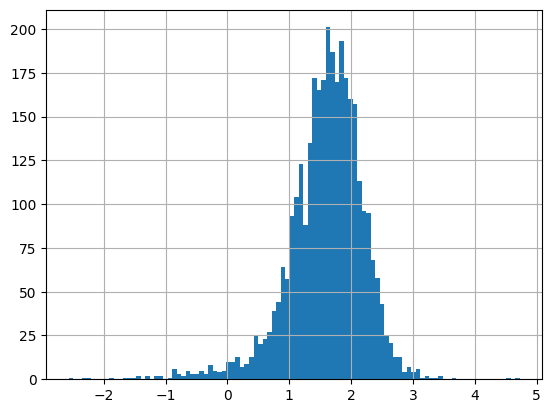

In [ ]:
df_wage.lwage.hist(bins=100)

In [ ]:
# unrelated

from scipy.stats import f

# parameters
d1 = 49
d2 = 24
alpha = 0.05

# critical value at 5% level (upper tail)
f_crit = f.ppf(1 - alpha, d1, d2)
f_crit


1.8649778841058862